<a href="https://colab.research.google.com/github/eneesbudaak/PythonCourse/blob/master/K3_adl%C4%B1_dosyan%C4%B1n_kopyas%C4%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import gzip
import shutil
import re
import string
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from mlxtend.preprocessing import TransactionEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from sentence_transformers import SentenceTransformer
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

stop_words = set(ENGLISH_STOP_WORDS)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# --- 1. .gz Dosyasını Aç ve CSV Olarak Kaydet ---
gz_path = "/content/drive/MyDrive/en.openfoodfacts.org.products.csv.gz"
csv_path = "/content/drive/MyDrive/products.csv"
with gzip.open(gz_path, 'rb') as f_in:
    with open(csv_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)


In [ ]:
# --- 2. CSV'yi Parça Parça Oku, Gerekli Sütunlar ---
chunks = pd.read_csv(
    csv_path, sep='\t',
    usecols=["product_name", "categories", "ingredients_text", "purchase_places"],
    chunksize=100000, low_memory=False
)

#  Eksik verileri at ve chunkları listeye ekle
df_list = []
for chunk in chunks:
    chunk = chunk.dropna(subset=["product_name", "categories", "ingredients_text"])
    df_list.append(chunk)

df_food = pd.concat(df_list, ignore_index=True)


In [ ]:
# --- Tüm chunkları birleştir ---
df_food = pd.concat(df_list, ignore_index=True)


In [ ]:
df_ny = df_food[df_food["purchase_places"].str.contains("new york", case=False, na=False)].reset_index(drop=True)
df_ny

In [7]:
# --- 3. Temizleme Fonksiyonu ---
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()  # 1. Küçük harfe çevir
    text = re.sub(r"[^a-z\s]", "", text)  # 2. Noktalama ve sayı çıkar
    words = text.split()
    words = [w for w in words if w not in stop_words]  # 3. Stopword çıkar
    return " ".join(words)  # ✅ Temizlenmiş metni döndür

In [ ]:
# --- 4. full_text Oluştur ve Temizle (purchase_places dahil) ---
df_ny["full_text"] = (
    df_ny["product_name"].astype(str) + " " +
    df_ny["categories"].astype(str) + " " +
    df_ny["ingredients_text"].astype(str) + " " +
    df_ny["purchase_places"].astype(str))

df_ny["full_text_clean"] = df_ny["full_text"].apply(clean_text)


In [ ]:
# --- 5. Df görüntüleme ---
df_ny

In [8]:
# --- İçeriğe sahip mi değilmi
keywords = {
    "has_sugar": "sugar",
    "has_lactose": "lactose",
    "has_gluten": "gluten",
    "is_vegan": "vegan",
    "is_vegetarian": "vegetarian"
}

for col_name, keyword in keywords.items():
    df_ny[col_name] = df_ny["ingredients_text"].str.lower().str.contains(keyword, na=False).astype(int)


In [ ]:
df_ny

,product_name,categories,purchase_places,ingredients_text,full_text,full_text_clean,has_sugar,has_lactose,has_gluten,is_vegan,is_vegetarian,final_cluster
0,Organic Brown Rice Cake Thins,"Puffed cereal cakes,Puffed rice cakes",New York,"ORGANIC BROWN RICE, SEA SALT",Organic Brown Rice Cake Thins Puffed cereal ca...,organic brown rice cake thins puffed cereal ca...,0,0,0,0,0,8
1,Whole Green Cardamom,"Plant-based foods and beverages, Plant-based f...","New York,United States",green cardamom,Whole Green Cardamom Plant-based foods and bev...,green cardamom plantbased foods beverages plan...,0,0,0,0,0,7
2,Top of the Rock Spring Water,"Beverages, Waters, Spring waters, Mineral wate...",New York City,100% Spring Water,"Top of the Rock Spring Water Beverages, Waters...",rock spring water beverages waters spring wate...,0,0,0,0,0,3
3,Autumn Mix Mellowcreme Candy,"Snacks, Sweet snacks, Confectioneries","New York,USA","SUGAR, CORN SYRUP, CONFECTIONER'S GLAZE (SHELL...","Autumn Mix Mellowcreme Candy Snacks, Sweet sna...",autumn mix mellowcreme candy snacks sweet snac...,1,0,0,0,0,2
4,"Amp, energy, cherry blast","Beverages, Carbonated drinks, Artificially swe...","New York,USA","Carbonated water, high fructose corn syrup, ci...","Amp, energy, cherry blast Beverages, Carbonate...",amp energy cherry blast beverages carbonated d...,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
378,French pure butter cookies,"Snacks, Sweet snacks, Biscuits and cakes, Bisc...",New York,"unbleached wheat flour, sugar, butter 22%, who...","French pure butter cookies Snacks, Sweet snack...",french pure butter cookies snacks sweet snacks...,1,0,0,0,0,3
379,2× Spicy Hot Chicken Flavor Ramen,"plant-based-foods-and-beverages, plant-based-f...","Jamaica,New York,USA","noodle(76,7%): wheat flour(52%), tapioca starc...",2× Spicy Hot Chicken Flavor Ramen plant-based-...,spicy hot chicken flavor ramen plantbasedfoods...,1,0,1,0,0,3
380,Coconut Milk,"Beverages and beverages preparations, Plant-ba...","Deutschland,United States,New York",COCONUT MILK 100%,Coconut Milk Beverages and beverages preparati...,coconut milk beverages beverages preparations ...,0,0,0,0,0,7
381,Sparkling Watermelon Juice,Sparkling juice,New York,"WATERMELON JUICE, CARBON DIOXIDE, CITRIC ACID ...",Sparkling Watermelon Juice Sparkling juice WAT...,sparkling watermelon juice sparkling juice wat...,0,0,0,0,0,3


In [ ]:
print(df_ny["is_vegetarian"].value_counts())
print(df_ny["is_vegan"].value_counts())
print(df_ny["has_sugar"].value_counts())
print(df_ny["has_lactose"].value_counts())
print(df_ny["has_gluten"].value_counts())

In [9]:
# --- 6. BERT Modeli ile Embedding ---
model = SentenceTransformer("paraphrase-MiniLM-L6-v2")
print("Embedding oluşturuluyor...")
embeddings = model.encode(df_ny["full_text_clean"].tolist(), show_progress_bar=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding oluşturuluyor...


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

In [10]:
# --- 7. Cosine Similarity Matrisi ---
print("Benzerlik matrisi hesaplanıyor...")
similarity_matrix = cosine_similarity(embeddings)
print(similarity_matrix)

Benzerlik matrisi hesaplanıyor...
[[1.         0.37211752 0.20603341 ... 0.29994014 0.20320867 0.23761891]
 [0.37211752 1.0000002  0.30640343 ... 0.5759038  0.3248836  0.29053932]
 [0.20603341 0.30640343 1.         ... 0.29851824 0.29911342 0.35561368]
 ...
 [0.29994014 0.5759038  0.29851824 ... 0.9999999  0.26577234 0.31462428]
 [0.20320867 0.3248836  0.29911342 ... 0.26577234 0.99999964 0.87763083]
 [0.23761891 0.29053932 0.35561368 ... 0.31462428 0.87763083 0.9999999 ]]


In [11]:
2222222222222# --- 8. Öneri ve Grafik Fonksiyonu ---
def öneri_ve_grafik(indeks, sim_matrix, ürün_sayısı=5):
    sim_scores = sim_matrix[indeks].copy()
    sim_scores[indeks] = 0  # Kendini çıkar
    top_indices = np.argsort(sim_scores)[::-1][:ürün_sayısı]
    öneriler = df_ny.iloc[top_indices][["product_name", "categories"]].copy()
    skorlar = sim_scores[top_indices]

    print(f"Örnek ürün: {df_ny.iloc[indeks]['product_name']}\n")
    print("Önerilen ürünler ve benzerlik skorları:")
    for i, (isim, skor) in enumerate(zip(öneriler["product_name"], skorlar)):
        print(f"{i+1}. {isim} (Benzerlik: {skor:.4f})")

    plt.figure(figsize=(10,6))
    plt.barh(range(ürün_sayısı), skorlar, color='skyblue')
    plt.yticks(range(ürün_sayısı), öneriler["product_name"])
    plt.gca().invert_yaxis()
    plt.xlabel("Cosine Benzerlik Skoru")
    plt.title(f"\"{df_ny.iloc[indeks]['product_name']}\" için Top {ürün_sayısı} Öneri")
    plt.show()

Örnek ürün: Organic Brown Rice Cake Thins

Önerilen ürünler ve benzerlik skorları:
1. Vanilla white chocolate (Benzerlik: 0.6391)
2. Salted Caramel Killer Brownie (Benzerlik: 0.6094)
3. Coffee Cakes (Benzerlik: 0.6026)
4. French pure butter cookies (Benzerlik: 0.5995)
5. Instant Pistachio Pudding & Pie Filling (Benzerlik: 0.5971)
6. Double chocolate sliced loaf cake, double chocolate (Benzerlik: 0.5952)
7. Sweet Yellow Cornbread & Muffin Mix (Benzerlik: 0.5932)
8. Rstd Dandelion Root, Organic (Benzerlik: 0.5911)
9. Pizzelle Waffle Cookies (Benzerlik: 0.5890)
10. Vanilla Instant Pudding & Pie Filling (Benzerlik: 0.5847)


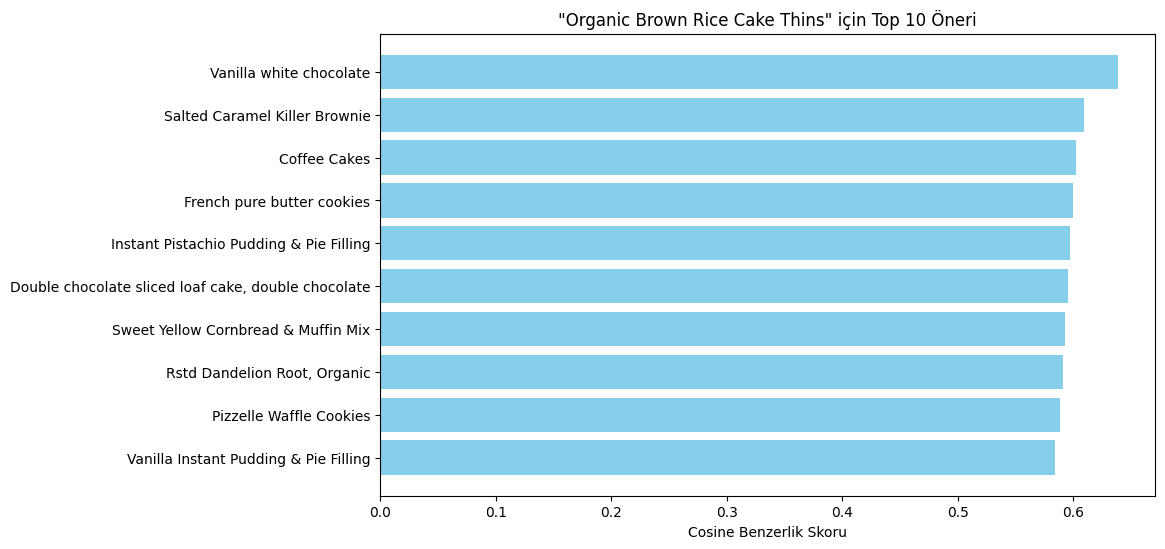

In [12]:
#  y.index için x adet öneri
öneri_ve_grafik(0, similarity_matrix, ürün_sayısı=10)

In [13]:
# --- 9. TF-IDF Alternatifi ---
tfidf = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf.fit_transform(df_ny["full_text_clean"])
tfidf_similarity = cosine_similarity(tfidf_matrix)
dense_matrix = tfidf_matrix.toarray()
feature_names = tfidf.get_feature_names_out()

In [14]:
feature_names = tfidf.get_feature_names_out()
print(feature_names[:20])  # İlk 20 kelime

['acacia' 'acesulfame' 'acid' 'acidifier' 'acidity' 'acids' 'acidulant'
 'acting' 'active' 'added' 'additives' 'adipic' 'adjustable' 'aestivum'
 'agar' 'agaragar' 'agaricus' 'aged' 'agent' 'agents']


In [15]:
def tfidf_grafik(indeks):
    row = dense_matrix[indeks]  # zaten numpy array → [n_features]
    top_indices = np.argsort(row)[::-1][:10]
    top_words = [feature_names[i] for i in top_indices]
    top_scores = row[top_indices]  # bu artık direkt array slice

    ürün_ismi = df_ny.iloc[indeks]["product_name"]

    plt.figure(figsize=(10, 6))
    plt.barh(range(10), top_scores, color='orange')
    plt.yticks(range(10), top_words)
    plt.gca().invert_yaxis()
    plt.xlabel("TF-IDF Skoru")
    plt.title(f"\"{ürün_ismi}\" ürününde en baskın 10 kelime")
    plt.tight_layout()
    plt.show()


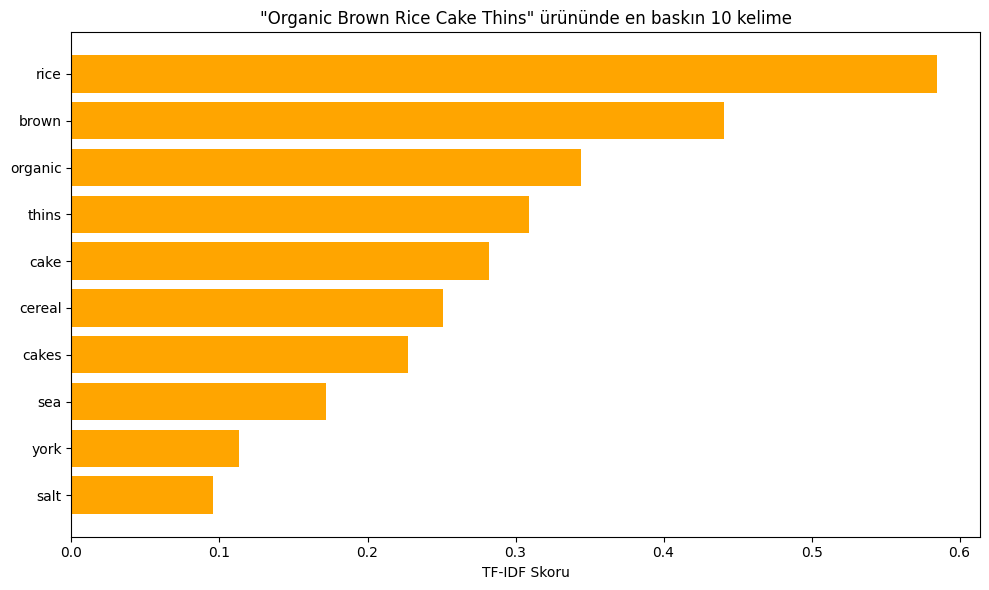

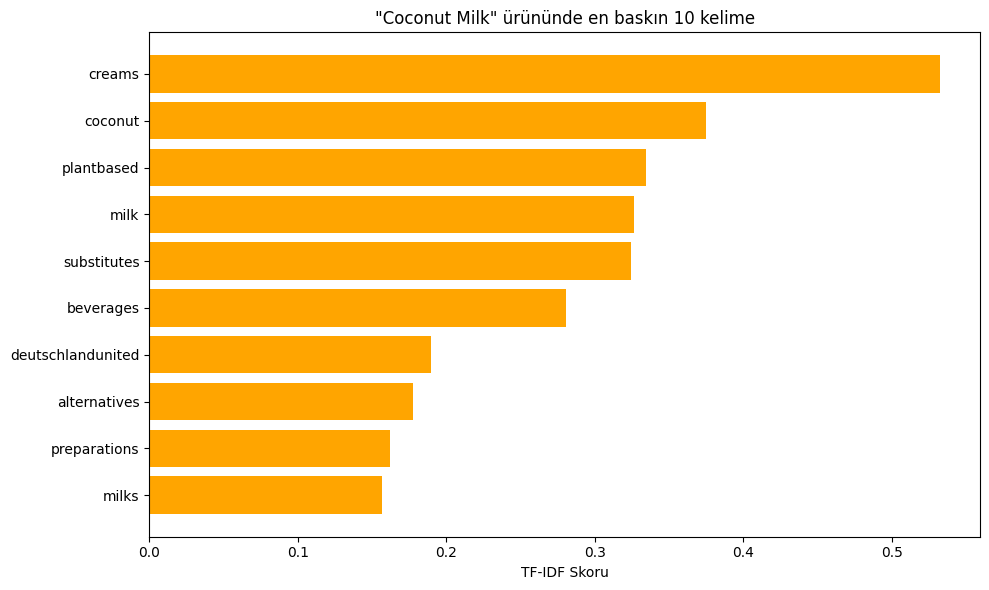

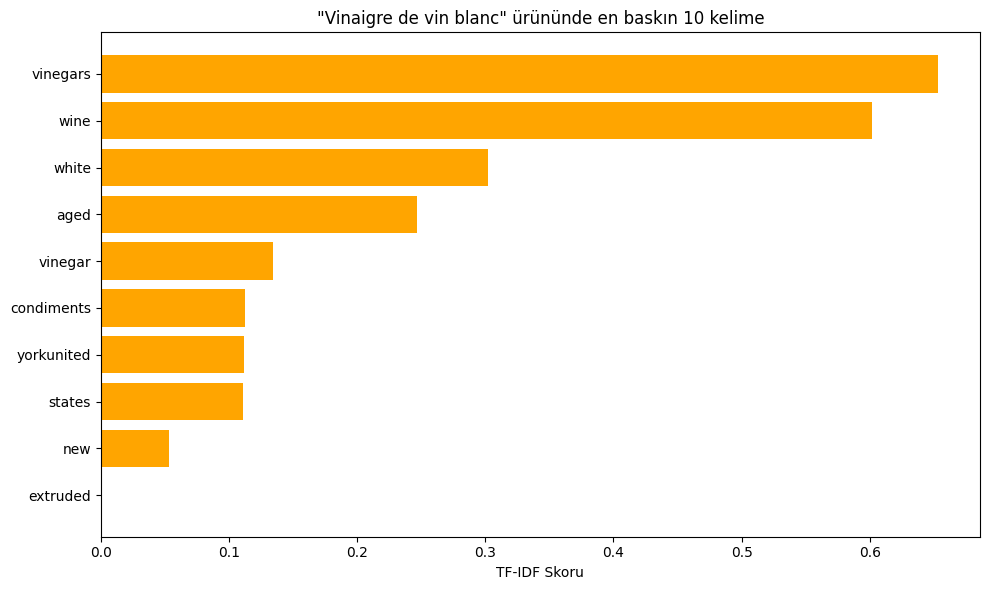

In [16]:
tfidf_grafik(0)
tfidf_grafik(380)
tfidf_grafik(50)

In [17]:
# --- 10. Apriori ile Cross-Sell Kuralları ---
category_lists = df_ny['categories'].str.lower().str.split(',')
te = TransactionEncoder()
te_ary = te.fit(category_lists).transform(category_lists)
df_tf = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = apriori(df_tf, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)


In [18]:
# --- En yüksek Lift değerine sahip 10 ürün
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head(10))


                                             antecedents                                        consequents   support  confidence   lift
9027                   ( cooking helpers,  sweet snacks)                          ( pastry helpers, snacks)  0.010444         1.0  95.75
9028                          ( cooking helpers, snacks)                   ( pastry helpers,  sweet snacks)  0.010444         1.0  95.75
44214  ( canned plant-based foods,  canned legumes,  ...  ( legumes,  canned common beans,  plant-based ...  0.010444         1.0  95.75
44215  ( canned foods,  canned plant-based foods,  ca...  ( legumes,  canned common beans,  plant-based ...  0.010444         1.0  95.75
44216  ( canned plant-based foods,  canned legumes, p...  ( legumes,  canned common beans,  plant-based ...  0.010444         1.0  95.75
44217  ( canned foods,  canned plant-based foods,  le...  ( legumes,  canned common beans,  plant-based ...  0.010444         1.0  95.75
44218  ( canned plant-based foods,  legum

In [19]:
# --- 11. Hibrit Öneri Fonksiyonu ---
def hibrit_öner(df, index, tfidf_sim, bert_sim, rules, top_n=5):
    tfidf_scores = tfidf_sim[index].copy()
    bert_scores = bert_sim[index].copy()
    combined = (tfidf_scores + bert_scores) / 2
    combined[index] = 0
    top_indices = np.argsort(combined)[::-1][:top_n]
    öneriler = df.iloc[top_indices]["product_name"].tolist()
    print(f"\n\033[1mHibrit öneri sonucu (TF-IDF + BERT)\033[0m")
    for i, ürün in enumerate(öneriler):
        print(f"{i+1}. {ürün} (skor: {combined[top_indices[i]]:.4f})")

Örnek ürün: Glacier Freeze Gatorade Frost

Önerilen ürünler ve benzerlik skorları:
1. Melting Snowman (Benzerlik: 0.7028)
2. Super Sour Scandinavian Swimmers (Benzerlik: 0.6277)
3. Liberty Cube (Benzerlik: 0.5887)
4. Autumn Sprinkle Mix (Benzerlik: 0.5865)
5. Ghoul’s Mix M&M's (Benzerlik: 0.5611)
6. Iced tea lemon flavor (Benzerlik: 0.5564)
7. Dairy-Free Frozen Dessert, Cardamon Pistachio (Benzerlik: 0.5518)
8. Amp, energy, cherry blast (Benzerlik: 0.5420)
9. Giant Marshmallows (Benzerlik: 0.5417)
10. Mini Marshmallows (Benzerlik: 0.5412)


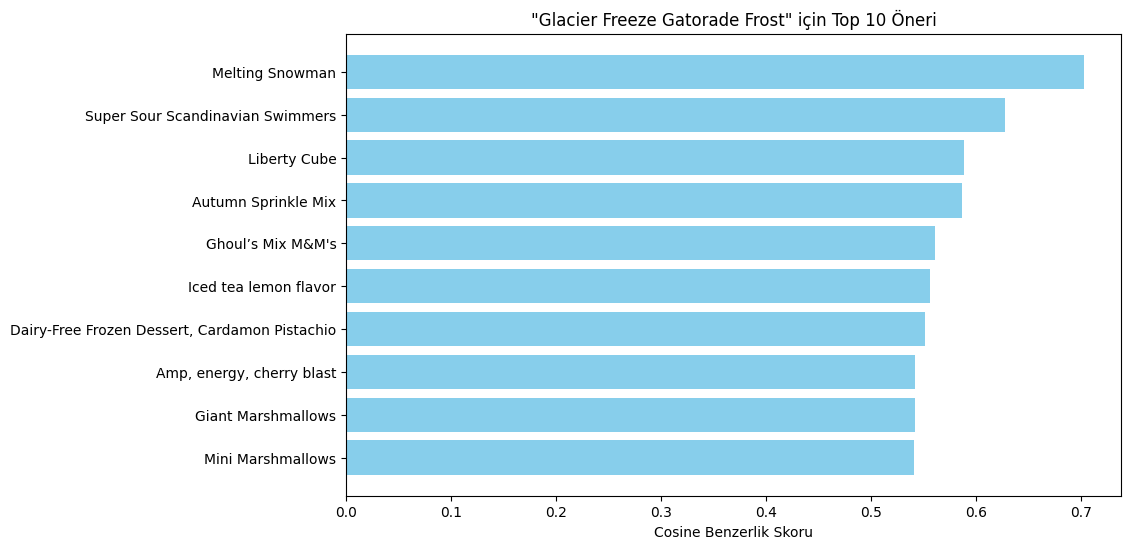


Hibrit öneri sonucu (TF-IDF + BERT)
1. Brown Rice Noodles (skor: 0.5316)
2. Vanilla white chocolate (skor: 0.5203)
3. Pad Thai Forbidden Rice Noodles (skor: 0.4896)
4. Gluten free lemon cookies (skor: 0.4529)
5. Sweet Potato Chips (skor: 0.4286)


In [20]:
# --- 12. Örnek Kullanım ---
öneri_ve_grafik(87, similarity_matrix, ürün_sayısı=10)
hibrit_öner(df_ny, 0, tfidf_similarity, similarity_matrix, rules)


In [21]:
def similarity_score(indeks, sim_matrix, df, n=5):
    """
    Verilen ürün indeksine göre en benzer n ürünü ve similarity skorlarını döner.

    Args:
        indeks (int): Öneri yapılacak ürünün indeksi
        sim_matrix (numpy.ndarray): Ürünler arası similarity matrisi
        df (pandas.DataFrame): Ürün bilgilerini içeren DataFrame (en az 'product_name' olmalı)
        n (int): Kaç ürün önerileceği

    Returns:
        List of tuples: [(ürün_ismi, similarity_skoru), ...]
    """
    sim_scores = sim_matrix[indeks].copy()
    sim_scores[indeks] = 0  # Kendini çıkar
    top_indices = sim_scores.argsort()[::-1][:n]

    öneriler = []
    for i in top_indices:
        isim = df.iloc[i]["product_name"]
        skor = sim_scores[i]
        öneriler.append((isim, skor))
    return öneriler

# Örnek kullanım:
indeks = 0  # İlk ürün için
benzer_urunler = similarity_score(indeks, similarity_matrix, df_ny, n=5)

In [22]:
similarity_score(0, similarity_matrix, df_ny, n=5)

[('Vanilla white chocolate', np.float32(0.6390823)),
 ('Salted Caramel Killer Brownie', np.float32(0.60940576)),
 ('Coffee Cakes', np.float32(0.602602)),
 ('French pure butter cookies', np.float32(0.5994556)),
 ('Instant Pistachio Pudding & Pie Filling', np.float32(0.59709084))]

In [ ]:
df_ny.to_csv("/content/drive/MyDrive/df_ny_final.csv", index=False)


NameError: name 'df_ny' is not defined

In [6]:
df_ny = pd.read_csv("/content/drive/MyDrive/df_ny_final.csv")

In [ ]:
df_ny

,product_name,categories,purchase_places,ingredients_text,full_text,full_text_clean,has_sugar,has_lactose,has_gluten,is_vegan,is_vegetarian,cluster,final_cluster
0,Organic Brown Rice Cake Thins,"Puffed cereal cakes,Puffed rice cakes",New York,"ORGANIC BROWN RICE, SEA SALT",Organic Brown Rice Cake Thins Puffed cereal ca...,organic brown rice cake thins puffed cereal ca...,0,0,0,0,0,1,8
1,Whole Green Cardamom,"Plant-based foods and beverages, Plant-based f...","New York,United States",green cardamom,Whole Green Cardamom Plant-based foods and bev...,green cardamom plantbased foods beverages plan...,0,0,0,0,0,3,7
2,Top of the Rock Spring Water,"Beverages, Waters, Spring waters, Mineral wate...",New York City,100% Spring Water,"Top of the Rock Spring Water Beverages, Waters...",rock spring water beverages waters spring wate...,0,0,0,0,0,0,3
3,Autumn Mix Mellowcreme Candy,"Snacks, Sweet snacks, Confectioneries","New York,USA","SUGAR, CORN SYRUP, CONFECTIONER'S GLAZE (SHELL...","Autumn Mix Mellowcreme Candy Snacks, Sweet sna...",autumn mix mellowcreme candy snacks sweet snac...,1,0,0,0,0,1,2
4,"Amp, energy, cherry blast","Beverages, Carbonated drinks, Artificially swe...","New York,USA","Carbonated water, high fructose corn syrup, ci...","Amp, energy, cherry blast Beverages, Carbonate...",amp energy cherry blast beverages carbonated d...,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,French pure butter cookies,"Snacks, Sweet snacks, Biscuits and cakes, Bisc...",New York,"unbleached wheat flour, sugar, butter 22%, who...","French pure butter cookies Snacks, Sweet snack...",french pure butter cookies snacks sweet snacks...,1,0,0,0,0,1,3
379,2× Spicy Hot Chicken Flavor Ramen,"plant-based-foods-and-beverages, plant-based-f...","Jamaica,New York,USA","noodle(76,7%): wheat flour(52%), tapioca starc...",2× Spicy Hot Chicken Flavor Ramen plant-based-...,spicy hot chicken flavor ramen plantbasedfoods...,1,0,1,0,0,1,3
380,Coconut Milk,"Beverages and beverages preparations, Plant-ba...","Deutschland,United States,New York",COCONUT MILK 100%,Coconut Milk Beverages and beverages preparati...,coconut milk beverages beverages preparations ...,0,0,0,0,0,3,7
381,Sparkling Watermelon Juice,Sparkling juice,New York,"WATERMELON JUICE, CARBON DIOXIDE, CITRIC ACID ...",Sparkling Watermelon Juice Sparkling juice WAT...,sparkling watermelon juice sparkling juice wat...,0,0,0,0,0,0,3


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pandas as pd

# TF-IDF Vektörleştirme
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X = tfidf.fit_transform(df_ny['full_text_clean'])

# Metrikleri tutacak liste
metrics = []

for k in range(2, 11):  # k = 2'den 10'a kadar dene
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)

    sil = silhouette_score(X, labels)
    db = davies_bouldin_score(X.toarray(), labels)
    ch = calinski_harabasz_score(X.toarray(), labels)

    metrics.append({'k': k, 'silhouette': sil, 'davies_bouldin': db, 'calinski_harabasz': ch})

# DataFrame olarak göster
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

    k  silhouette  davies_bouldin  calinski_harabasz
0   2    0.026632        5.535680          11.508489
1   3    0.028421        5.494794           9.297559
2   4    0.031012        4.598138           9.076579
3   5    0.035410        4.696814           8.447429
4   6    0.033719        4.350984           7.932583
5   7    0.041639        4.155606           7.751412
6   8    0.042875        4.233107           7.553492
7   9    0.045899        4.333078           7.086386
8  10    0.051258        4.002540           7.032249


In [24]:
from sklearn.cluster import KMeans

# Final KMeans modeli
final_kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
df_ny['final_cluster'] = final_kmeans.fit_predict(X)


In [26]:
# Her kümeden 5 örnek ürün ismi ve kategori
cluster_samples = df_ny.groupby('final_cluster').apply(
    lambda x: x[['product_name', 'categories']].head(5)
).reset_index(level=0)

# Görüntüle
print(cluster_samples)


     final_cluster                                       product_name                                         categories
8                0                                 Kosher Salt Flakes                                  Condiments, Salts
50               0                              Vinaigre de vin blanc  Condiments, Vinegars, Wine vinegars, White win...
123              0                         Balsamic Vinegar of Modena  Condiments, Vinegars, Balsamic vinegars, Balsa...
147              0                                       Rice Vinegar                Condiments, Vinegars, Rice vinegars
206              0                             Roasted Chipotle Salsa  Condiments, Sauces, Dips, Salad dressings, Dre...
7                1                Sweet Yellow Cornbread & Muffin Mix  Snacks, Sweet snacks, Biscuits and cakes, Cake...
11               1                                  Goldfish crackers  snacks, salty-snacks, sweet-snacks, appetizers...
20               1              

/tmp/ipython-input-861286085.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_samples = df_ny.groupby('final_cluster').apply(


In [27]:
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN, AgglomerativeClustering, Birch, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pandas as pd
import numpy as np

# === 1. Veri ===
# Burada X senin verin olacak (TF-IDF matrisin veya sayısal veri)
# Örnek: X = tfidf.fit_transform(df['text'])
# X.toarray() gerekiyorsa ekle

# Parametreler
n_clusters = 10  # Küme sayısı (biliniyorsa)
results = []

# === 2. Modeller ===
models = {
    "KMeans": KMeans(n_clusters=n_clusters, random_state=42, n_init=10),
    "MiniBatchKMeans": MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=256),
    "Agglomerative": AgglomerativeClustering(n_clusters=n_clusters),
    "GaussianMixture": GaussianMixture(n_components=n_clusters, random_state=42),
    "Birch": Birch(n_clusters=n_clusters),
    "SpectralClustering": SpectralClustering(n_clusters=n_clusters, random_state=42, affinity='nearest_neighbors'),
    # DBSCAN küme sayısını otomatik bulur
    "DBSCAN": DBSCAN(eps=0.5, min_samples=5)
}

# === 3. Modelleri çalıştır ve skorları kaydet ===
for name, model in models.items():
    try:
        if name == "GaussianMixture":
            labels = model.fit_predict(X.toarray() if hasattr(X, "toarray") else X)
        else:
            labels = model.fit_predict(X)

        # Tüm noktalar tek kümede ise metrik hesaplamayı atla
        if len(set(labels)) > 1 and -1 not in set(labels):
            sil_score = silhouette_score(X, labels)
            db_score = davies_bouldin_score(X.toarray() if hasattr(X, "toarray") else X, labels)
            ch_score = calinski_harabasz_score(X.toarray() if hasattr(X, "toarray") else X, labels)
        else:
            sil_score, db_score, ch_score = np.nan, np.nan, np.nan

        results.append([name, sil_score, db_score, ch_score])

    except Exception as e:
        results.append([name, np.nan, np.nan, np.nan])
        print(f"{name} hata verdi: {e}")

# === 4. Sonuçları tablo olarak göster ===
df_results = pd.DataFrame(results, columns=["Model", "Silhouette", "Davies-Bouldin", "Calinski-Harabasz"])
print(df_results.sort_values(by="Silhouette", ascending=False))


Agglomerative hata verdi: Sparse data was passed for X, but dense data is required. Use '.toarray()' to convert to a dense numpy array.
                Model  Silhouette  Davies-Bouldin  Calinski-Harabasz
0              KMeans    0.051258        4.002540           7.032249
5  SpectralClustering    0.049607        3.990009           6.753014
3     GaussianMixture    0.049221        4.225383           6.838957
1     MiniBatchKMeans    0.044333        3.871563           6.394907
4               Birch    0.039113        3.607894           6.307932
2       Agglomerative         NaN             NaN                NaN
6              DBSCAN         NaN             NaN                NaN
